In [1]:
import numpy as np
from tqdm import tqdm

from system import (
    rows,
    cols,
    states,
    s_state,
    wind_col,
    num_states,
    num_actions,
    init_mdp,
    init_reward,
    to_idx,
    get_valid_actions,
    gen_random_sa,
)
from model import Model
from policy import Policy, PolicyInit
from agent import Agent

In [31]:
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=0)

model = Model(mdp, reward)

policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

agent = Agent(model, policy)

In [49]:
Q_val = np.random.uniform(-10, -1, (num_states, num_actions))
returns = [[[] for a in range(num_actions)] for s in range(num_states)]
episodic_reward = []

i = 0
T = 1000
gamma = 0.9

for i in tqdm(range(100000)):
    start_state, start_action = gen_random_sa()
    estates, eactions, erewards = agent.gen_episode(start_state, start_action, T)
    T = len(erewards) # Early termination
    fo = {}
    for j in range(T):
        s = tuple(estates[j])
        a = eactions[j]
        # r = erewards[j]
        if (s, a) not in fo:
            fo[(s, a)] = j
    g = 0
    
    for j in range(T):
        s = tuple(estates[T - j - 1])
        a = eactions[T - j - 1]
        r = erewards[T - j - 1]
        g = gamma * g + r
        if T - j - 1 == fo[(s, a)]:
            returns[to_idx(s)][a].append(g)
            Q_val[to_idx(s), a] = np.mean(returns[to_idx(s)][a])
            # policy.set_action(np.array(s), np.argmax(Q_val[to_idx(s)]))
    
    # valf_list.append(np.max(Q_val, axis=1))
    for s, a in fo.keys():
        valid_actions = get_valid_actions(s, idx=True)
        action = valid_actions[np.argmax(Q_val[to_idx(s)][valid_actions])]
        policy.set_action(s, action)
    episodic_reward.append(np.max(Q_val[to_idx(s_state)][get_valid_actions(s_state, idx=True)]))
    agent.change_policy(policy)

100%|██████████| 100000/100000 [09:53<00:00, 168.41it/s]


In [50]:
valf = []
for s in states: 
    valid_actions = get_valid_actions(s, idx=True)
    valf.append(np.max(Q_val[to_idx(s)][valid_actions]))
valf = np.array(valf)

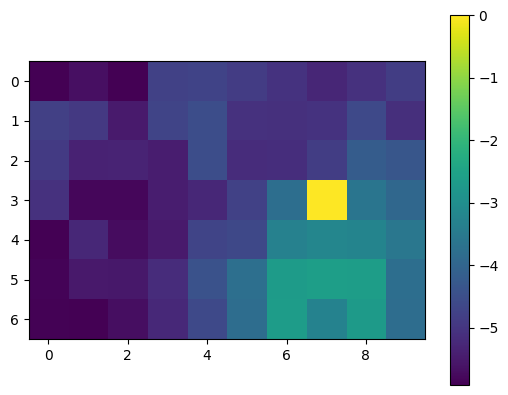

In [51]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

In [52]:
print(valf[to_idx(s_state)])

-5.077994469900526


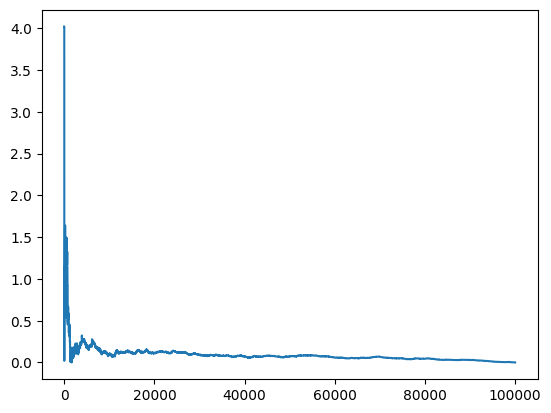

In [53]:
episodic_regret = np.abs(episodic_reward - valf[to_idx(s_state)])
plt.plot(episodic_regret)

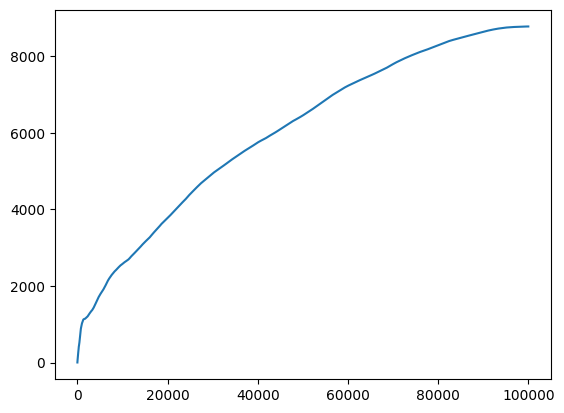

In [54]:
cummulative_regret = np.cumsum(episodic_regret)
plt.plot(cummulative_regret)

In [55]:
path, score = agent.play(model, policy, np.array([3,0]), 1000)

State: [3 0], Action: [-1  0], Next State: [2 0], Reward: -1
State: [2 0], Action: [-1  1], Next State: [1 1], Reward: -1
State: [1 1], Action: [ 0 -1], Next State: [1 0], Reward: -1
State: [1 0], Action: [0 1], Next State: [1 1], Reward: -1
State: [1 1], Action: [ 0 -1], Next State: [1 0], Reward: -1
State: [1 0], Action: [0 1], Next State: [1 1], Reward: -1
State: [1 1], Action: [ 0 -1], Next State: [1 0], Reward: -1
State: [1 0], Action: [0 1], Next State: [1 1], Reward: -1
State: [1 1], Action: [ 0 -1], Next State: [1 0], Reward: -1
State: [1 0], Action: [0 1], Next State: [1 1], Reward: -1
State: [1 1], Action: [ 0 -1], Next State: [1 0], Reward: -1
State: [1 0], Action: [0 1], Next State: [1 1], Reward: -1
State: [1 1], Action: [ 0 -1], Next State: [1 0], Reward: -1
State: [1 0], Action: [0 1], Next State: [1 1], Reward: -1
State: [1 1], Action: [ 0 -1], Next State: [1 0], Reward: -1
State: [1 0], Action: [0 1], Next State: [1 1], Reward: -1
State: [1 1], Action: [ 0 -1], Next St

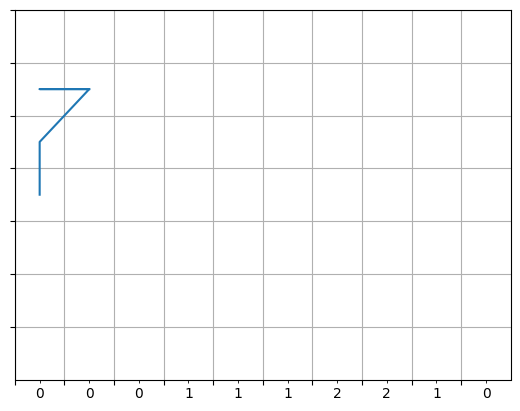

In [56]:

path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()